# Employment Recommender Systems
# Using Natural Language Processing

## Script 2 - Topic modelling

By Erik Konstenius, Danielle Duncan, Muhammed Azkaenza and Elias Aslaksen

In [36]:
!pip install -r requirements.txt

In [2]:
# Uncategorized
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from colorama import Fore
from wordcloud import WordCloud
from IPython.core.display import display, HTML
from top2vec import Top2Vec
from textwrap import fill
import tensorflow as tf # maybe not necessary
import re
import missingno as msno
import os
import textract
from langdetect import detect
import copy
from matplotlib.pyplot import figure

# gensim
import gensim
from gensim import corpora, models
import gensim.downloader as api
from gensim.models import TfidfModel, Nmf, CoherenceModel, LdaMulticore
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import preprocess_string, strip_punctuation,strip_numeric
from gensim.corpora.dictionary import Dictionary
import operator
from IPython.core.display import display, HTML
from matplotlib.pyplot import figure
import seaborn as sns
#from gensim.parsing.preprocessing import remove_stopwords

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import *

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.decomposition import NMF

## Download and Load dataset

### Get the dataset:
##### Download manually:
- Download the dataset from google drive with this link:                                    
https://drive.google.com/drive/folders/1mWKlOg1z5Le6QrXbYJ4yGld4h6Dhrp0-?usp=sharing
- Save them in the same folder as this jupyter notebook file

##### OR use code as below:

In [37]:
job_data = pd.read_excel('clean_data.xlsx', index_col=0)
job_data.head()

,Position,Link,Company,Date,Description,Seniority_level,Employment_type,Department,Industry,Country,City,Language,Clean_description
0,English Teacher,https://at.linkedin.com/jobs/view/english-teac...,English in Action,2022-04-20,['English in Action is looking for qualified E...,NaN,Contract,NaN,NaN,Austria,Vienna,en,english action qualified english teachers pgc...
1,Office Assistant,https://at.linkedin.com/jobs/view/office-assis...,BAMBINIFASHION.COM,2022-04-29,['WHO WE ARE..BAMBINIFASHION.COM\xa0is one of ...,NaN,Full-time,NaN,NaN,Austria,Vienna,en,who are bambinifashion com europe premier ch...
2,Recruiter at Central European University,https://at.linkedin.com/jobs/view/recruiter-at...,join.com,2022-05-07,['Starting date: As soon as possible..Applicat...,Associate,Full-time,Human Resources,Higher Education,Austria,Vienna,en,starting date possible application deadline ...
3,Program Assistant,https://at.linkedin.com/jobs/view/program-assi...,Vienna Master of Arts in Applied Human Rights,2022-04-29,['The Vienna Master of Arts in Applied Human R...,NaN,Internship,NaN,NaN,Austria,Vienna,en,the vienna master arts applied human rights un...
4,Customer Service Representative,https://at.linkedin.com/jobs/view/customer-ser...,LIPOELASTIC Österreich,2022-05-06,['Customer Service & Office Assistant..Cosmeti...,NaN,Full-time,NaN,NaN,Austria,Vienna,en,customer service office assistant cosmetic ...


Tokenize and lemmatize

In [22]:
texts = [word_tokenize(i) for i in job_data["Clean_description"]]
temp = []
lemmatizer = WordNetLemmatizer()
for doc in texts: 
    temp.append([lemmatizer.lemmatize(word) for word in doc]) # lemmatize each word in each doc
texts = temp

In [23]:
dictionary = corpora.Dictionary(texts)
bow_texts = [dictionary.doc2bow(description) for description in texts]

# Topic modelling

### LDA

#### Create model and tune parameter in searching for highest coherence score

In [ ]:
# create the LDA model and calculate its coherence score for a range number of topics assigned
# Ucloud was used with 64 cores machine
# worker parameter in LdaMulticore is specified as 63 to use maximum capacity of the processors in speeding up the training

lda_models = []
coherence_lda = []
    
for topics in tqdm.tqdm(range(1, 101, 5)):
    lda = LdaMulticore(corpus = bow_texts,
                       id2word=dictionary,
                       num_topics=topics,
                       passes=10, # epochs
                       workers=63) 
    lda_models.append(lda)
    
    coherence_model_lda = CoherenceModel(model=lda, texts=texts, coherence='c_v')
    coherence_lda.append(coherence_model_lda.get_coherence())

#### Plot parameter tuning result

Text(0.5, 0, 'Number of topics')

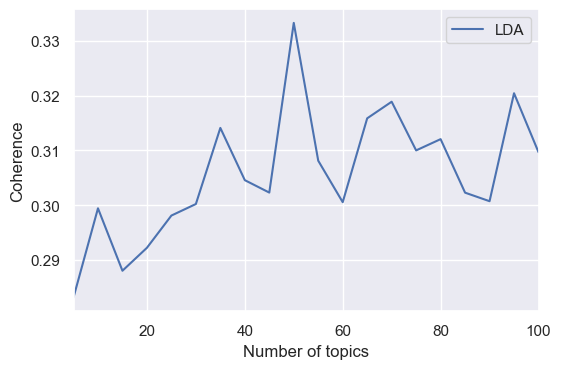

In [26]:
# graph of LDA coherence score according to number of topics
sns.set_style("whitegrid")
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.lineplot(data=coherence_lda)
plt.xlim(5,100)
plt.ylabel("Coherence")
plt.xlabel("Number of topics")

#### Create model with 70 topics as parameter

In [ ]:
# create the LDA model and calculate its coherence score for 70 topics
lda70 = LdaMulticore(corpus = bow_texts, id2word=dictionary, num_topics=70, passes=10, workers=63)
coherence_model_lda70 = CoherenceModel(model=lda70, texts=texts, coherence='c_v')
print('\nCoherence Score (LDA with 70 Topics) : ', coherence_model_lda70.get_coherence())

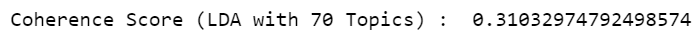

#### Visualize the topics for observation

In [ ]:
# WordCloud of LDA Topics
for topic in range(lda70.num_topics):
    plt.figure(figsize=(40,5))
    plt.imshow(WordCloud(width=800, height=400).fit_words(dict(lda70.show_topic(topic, 300))))
    plt.axis("off")
    plt.title("Topic #" + str(topic))
    plt.show()

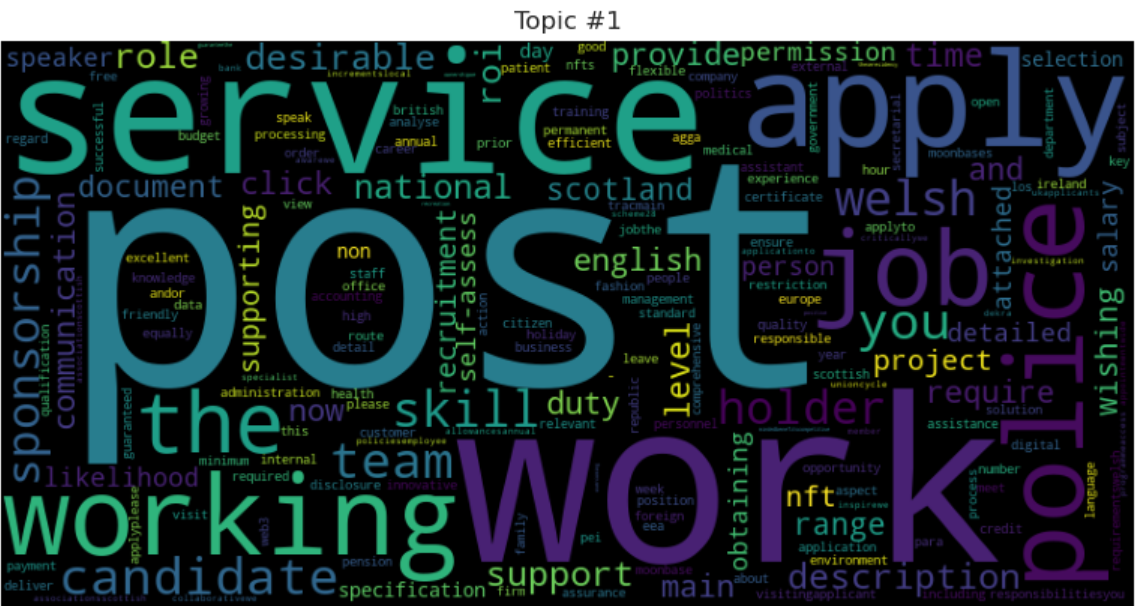

In [ ]:
# extract topics from LDA model into list of topics
topics_l = []
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]
for topic in lda70.show_topics(num_words=50):
    topics_l.append(preprocess_string(topic[1], filters))
    
# Convert list of topics to dataframe. Each row equals one topics. Showing the 50 most important 
# words for that topics.
lda_topics = pd.DataFrame(topics_l)

In [31]:
lda_topics

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,customer,work,support,company,marketing,event,working,you,team,service,...,level,benefit,portugal,including,opportunity,leader,skillsgood,professional,NaN,NaN
1,post,work,service,apply,working,police,job,the,candidate,you,...,speaker,person,salary,obtaining,self,assess,detailed,attached,specification,NaN
2,customer,business,team,role,product,client,opportunity,sale,relationship,day,...,job,market,level,growth,visual,partner,strategy,NaN,NaN,NaN
3,barclays,business,support,team,working,work,campus,financial,opportunity,you,...,deepen,reach,tradeston,location,NaN,NaN,NaN,NaN,NaN,NaN
4,business,financial,risk,client,finance,team,credit,management,skill,work,...,people,environment,firm,area,relationship,trading,join,relevant,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,customer,youll,work,working,role,team,sky,hour,service,support,...,social,brilliant,bank,brand,week,our,understand,NaN,NaN,NaN
66,team,company,you,business,work,role,office,client,working,skill,...,position,professional,experience,language,environment,operation,sale,NaN,NaN,NaN
67,work,team,service,process,knowledge,skill,support,business,accounting,recruitment,...,responsible,opportunity,customer,candidate,http,employee,spark,NaN,NaN,NaN
68,school,application,work,post,support,you,group,lothian,communication,team,...,position,management,customer,committed,complete,business,vulnerable,NaN,NaN,NaN


### NMF

#### Create model and tune parameter in searching for highest coherence score

In [ ]:
# create the NMF model and calculate its coherence score for a range number of topics assigned
nmf_models = []
coherence_nmf = []
    
for topics in tqdm.tqdm(range(1, 101, 5)):
    nmf = Nmf(corpus = bow_texts, id2word=dictionary, num_topics=topics, passes=10)
    nmf_models.append(nmf)
    
    coherence_model_nmf = CoherenceModel(model=nmf, texts=texts, coherence='c_v')
    coherence_nmf.append(coherence_model_nmf.get_coherence())

#### Plot parameter tuning result

Text(0.5, 0, 'Number of topics')

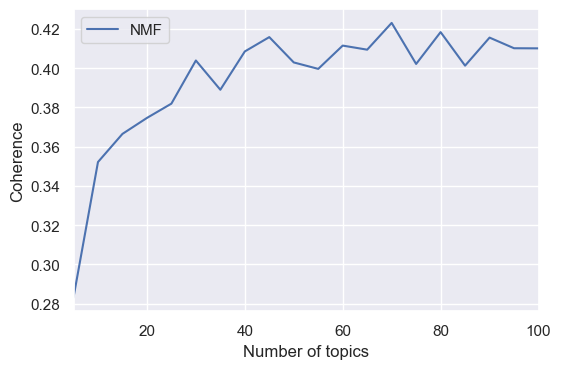

In [33]:
# graph of NMF coherence score according to number of topics
sns.set_style("whitegrid")
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.lineplot(data=coherence_nmf)
plt.xlim(5,100)
plt.ylabel("Coherence")
plt.xlabel("Number of topics")

#### Create model with 70 topics as parameter

In [ ]:
# create the NMF model and calculate its coherence score for 70 topics
nmf70 = Nmf(corpus = bow_texts, id2word=dictionary, num_topics=70, passes=10)
coherence_model_nmf70 = CoherenceModel(model=nmf70, texts=texts, coherence='c_v')
print('\nCoherence Score (NMF with 70 Topics) : ', coherence_model_nmf70.get_coherence())

#### Visualize the topics for observation

In [ ]:
# WordCloud of NMF Topics
for topic in range(nmf70.num_topics):
    plt.figure(figsize=(40,5))
    plt.imshow(WordCloud(width=800, height=400).fit_words(dict(nmf70.show_topic(topic, 300))))
    plt.axis("off")
    plt.title("Topic #" + str(topic))
    plt.show()

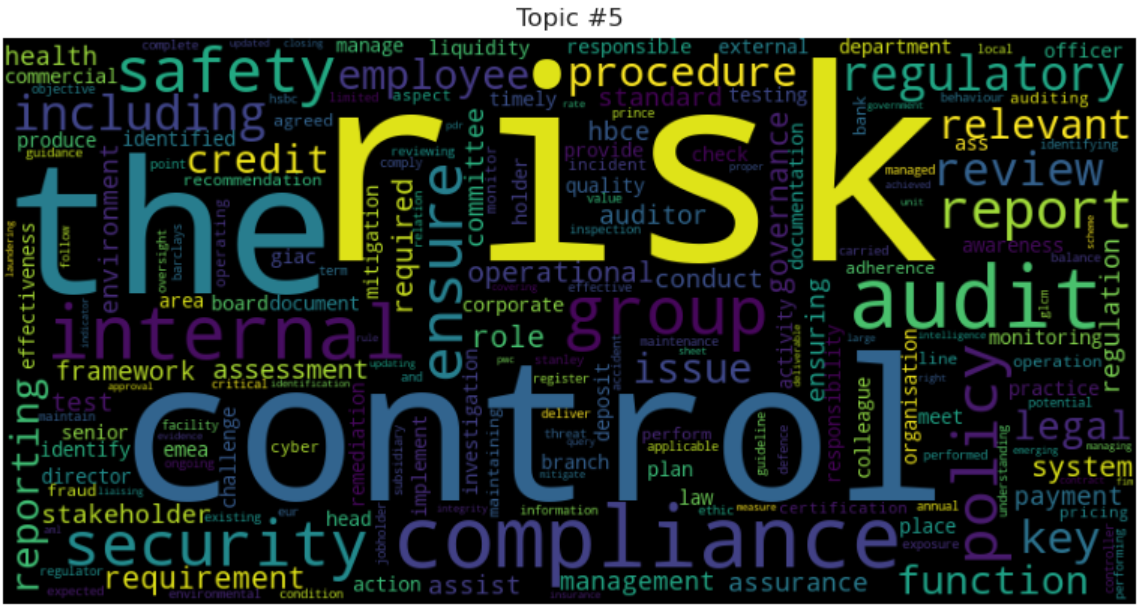

In [ ]:
# extract topics from NMF model into list of topics
topics_n = []
filters = [lambda x: x.lower(), strip_punctuation, strip_numeric]
for topic in nmf70.show_topics(num_words=50):
    topics_n.append(preprocess_string(topic[1], filters))
    
# Convert list of topics to dataframe. Each row equals one topics. Showing the 50 most important 
# words for that topics.
nmf_topics = pd.DataFrame(topics_n)

In [35]:
nmf_topics

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,the,style,font,family,time,serif,new,span,roman,cabin,...,active,offering,innovation,scc,minimum,founding,offer,area,about,NaN
1,team,working,role,you,people,this,communication,build,ensure,environment,...,head,culture,exceptional,creating,bbc,enjoy,grow,NaN,NaN,NaN
2,supply,chain,planning,team,product,operation,demand,logistics,inventory,stock,...,excel,met,country,master,were,strong,optimization,NaN,NaN,NaN
3,application,candidate,post,job,interview,recruitment,email,apply,form,note,...,term,offer,lothian,subject,including,nh,NaN,NaN,NaN,NaN
4,marketing,brand,work,opportunity,global,communication,creative,plan,year,consumer,...,with,nordic,ambitious,world,understanding,bring,drive,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,communication,the,skill,office,internal,external,work,english,support,position,...,include,coordinator,spoken,planning,science,life,microsoft,NaN,NaN,NaN
66,process,quality,internal,improvement,production,recruitment,support,knowledge,manufacturing,job,...,audit,written,automation,administration,payroll,data,implement,NaN,NaN,NaN
67,work,working,team,environment,office,day,technology,good,experience,year,...,tech,model,strong,attitude,hiring,expertise,alongside,diversity,NaN,NaN
68,data,platform,company,tool,performance,analytics,social,medium,world,user,...,analytical,industry,wolt,were,contribute,individual,etc,NaN,NaN,NaN


### Top2Vec

#### Creating the model

In [ ]:
# Lemmatization is not necessary for Top2Vec

# create the model
top2vec = Top2Vec(texts_not_lem, speed = 'deep-learn',  workers=12) 

In [ ]:
# Get number of detected topics.
print("Number of topics: " + str(top2vec.get_num_topics()))

#### Visualize topics

In [ ]:
display(HTML("<style>div.output_scroll { height: 60em; }</style>"))
figure(figsize=(8, 6), dpi=80)

# This will return the topics in decreasing size.
topic_words, word_scores, topic_nums = top2vec.get_topics(top2vec.get_num_topics())

# topic_words: For each topic the top 50 words are returned, in order of semantic similarity to topic.
# word_scores: For each topic the cosine similarity scores of the top 50 words to the topic are returned.
# topic_nums: The unique index of every topic will be returned.

for topic in topic_nums:
    top2vec.generate_topic_wordcloud(topic)

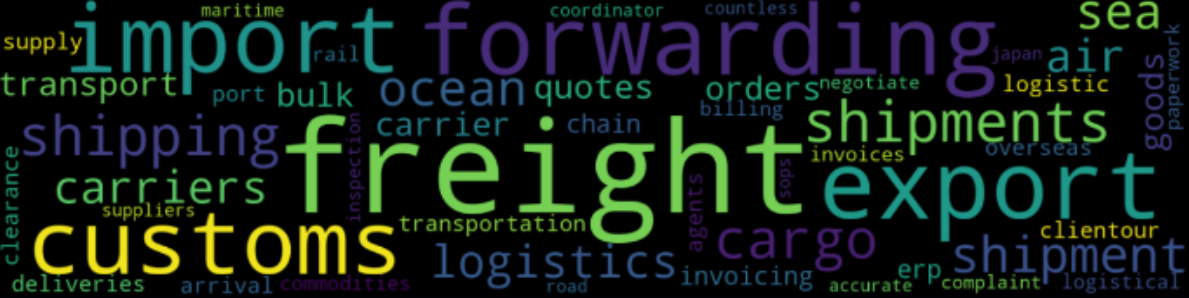

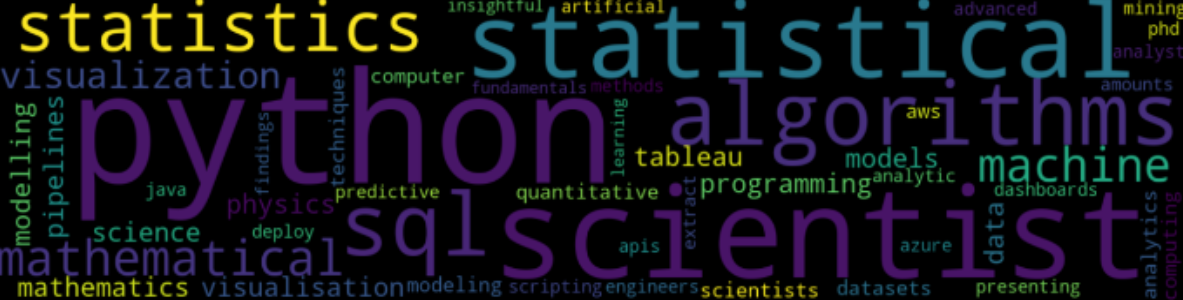

### Top2vec 70 topics

We find about 70 well separated topics. We will reduce the number of topics to 70 and see if we can get even better topics.

In [ ]:
 top2vec_70 = top2vec.hierarchical_topic_reduction(num_topics=70)

In [ ]:
# generate word cloud again
for index, topic in enumerate(top2vec.topic_words_reduced):
    unique_string=(" ").join(list(topic)) #convert topics to string
    plt.figure(figsize=(40,5))
    wordcloud = WordCloud(width = 1200, height = 300).generate(unique_string)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Topic #" + str(index))
    plt.show()
    plt.close()

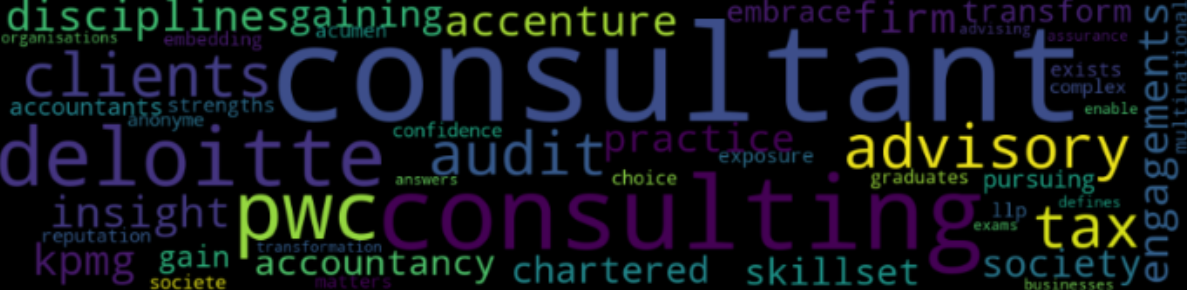

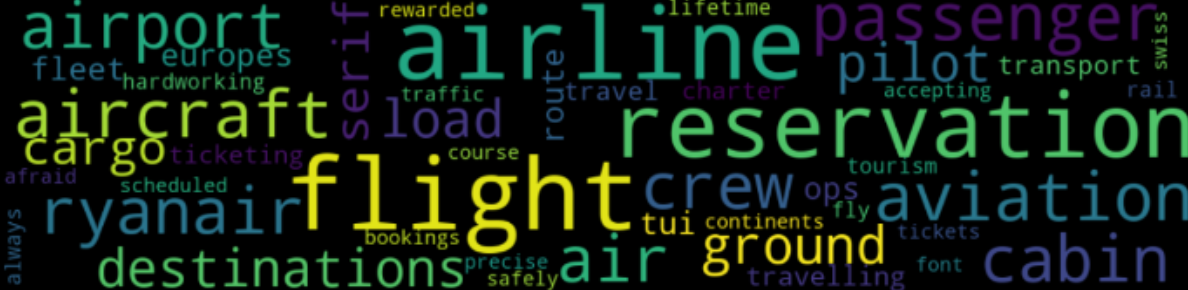

# Evaluation of topic modelling

We will use Top2Vec with 70 topics.

### Convert topics to dataframe

In [ ]:
pd.set_option('display.max_rows', 200)
top2vec_70_topics = pd.DataFrame(data = top2vec.topic_words_reduced)
top2vec_70_topics

In [ ]:
# download topics from best performing topic modelling technique
# these will be manually labelled
top2vec_70_topics.to_excel(os.getcwd()+'\\top2vec_topics.xlsx')